In [1]:
import os
import math
import random
import numpy as np
import random
import torch

import draw,utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Field_filename = "F3"
# Field_filename = "Poseidon"
Field_filename = "Beagle"
Modelname = "GLPmerge_cigfacies_L2SSIMCIGL1Norm_loraBeagle"

In [3]:
if Field_filename == "F3": 
    num_sample = 540
elif Field_filename == "Poseidon": 
    num_sample = 638
elif Field_filename == "Beagle": 
    num_sample = 800
else:
    print("num_sample are none")
    
Train_filename = "samples_"+Field_filename+"data.npy"
root_path = os.path.abspath(".")
dataset_name = 'field'
dataset_path = os.path.join(root_path, "dataset",dataset_name)
train_dataset_path = os.path.join(dataset_path, Field_filename+"_datasets_cigfacies")

if Train_filename == "samples_F3data.npy":
    ciglabel_path = os.path.join(dataset_path, "F3_datasets_ciglabel/")
elif Train_filename == "samples_Poseidondata.npy":
    ciglabel_path = os.path.join(dataset_path, "Poseidon_datasets_ciglabel/")
elif Train_filename == "samples_Beagledata.npy":
    ciglabel_path = os.path.join(dataset_path, "Beagle_datasets_ciglabel/")
else:
    print("wrong!")

if os.path.exists(os.path.join(dataset_path,Train_filename)) is False:
    sample_name_list = []
    for i in range(num_sample):
        train_sample_file = f'{i}'
        sample_name_list.append(train_sample_file)
    num_data_sample = len(sample_name_list)
    samples_valid = []
    for sample_name in sample_name_list[:num_sample]:
        samples_valid.append(sample_name)
    
    np.save(os.path.join(dataset_path,Train_filename), samples_valid)

In [4]:
os.environ['CUDA_VISIBLE_DEVICES']= '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU 数量: {num_GPU}")
print(f"运行平台: {device}")
root_path = os.path.abspath('.')

GPU 数量: 1
运行平台: cuda


In [5]:
samples_train = np.load(os.path.join(dataset_path, Train_filename), allow_pickle=True)
print(f"训练样本数量: {len(samples_train)}")

train_sample_path = os.path.join(dataset_path,  Field_filename+"_datasets_cigfacies")
input_attr_list, input_attr_list2 = ["seis"], ["cigfacies"]  
input_attr_list3,input_attr_list4 = ["normal"], ["linearity"]
output_attr_list, output_attr_list2 = ["label"], ["label"]

训练样本数量: 800


In [6]:
train_data =  utils.build_dataset_cigfacies(samples_train, train_sample_path, 'Train',
                                            input_attr_list=input_attr_list,input_attr_list2=input_attr_list2,
                                            input_attr_list3=input_attr_list3,input_attr_list4=input_attr_list4,
                                            output_attr_list=output_attr_list, output_attr_list2=output_attr_list2)

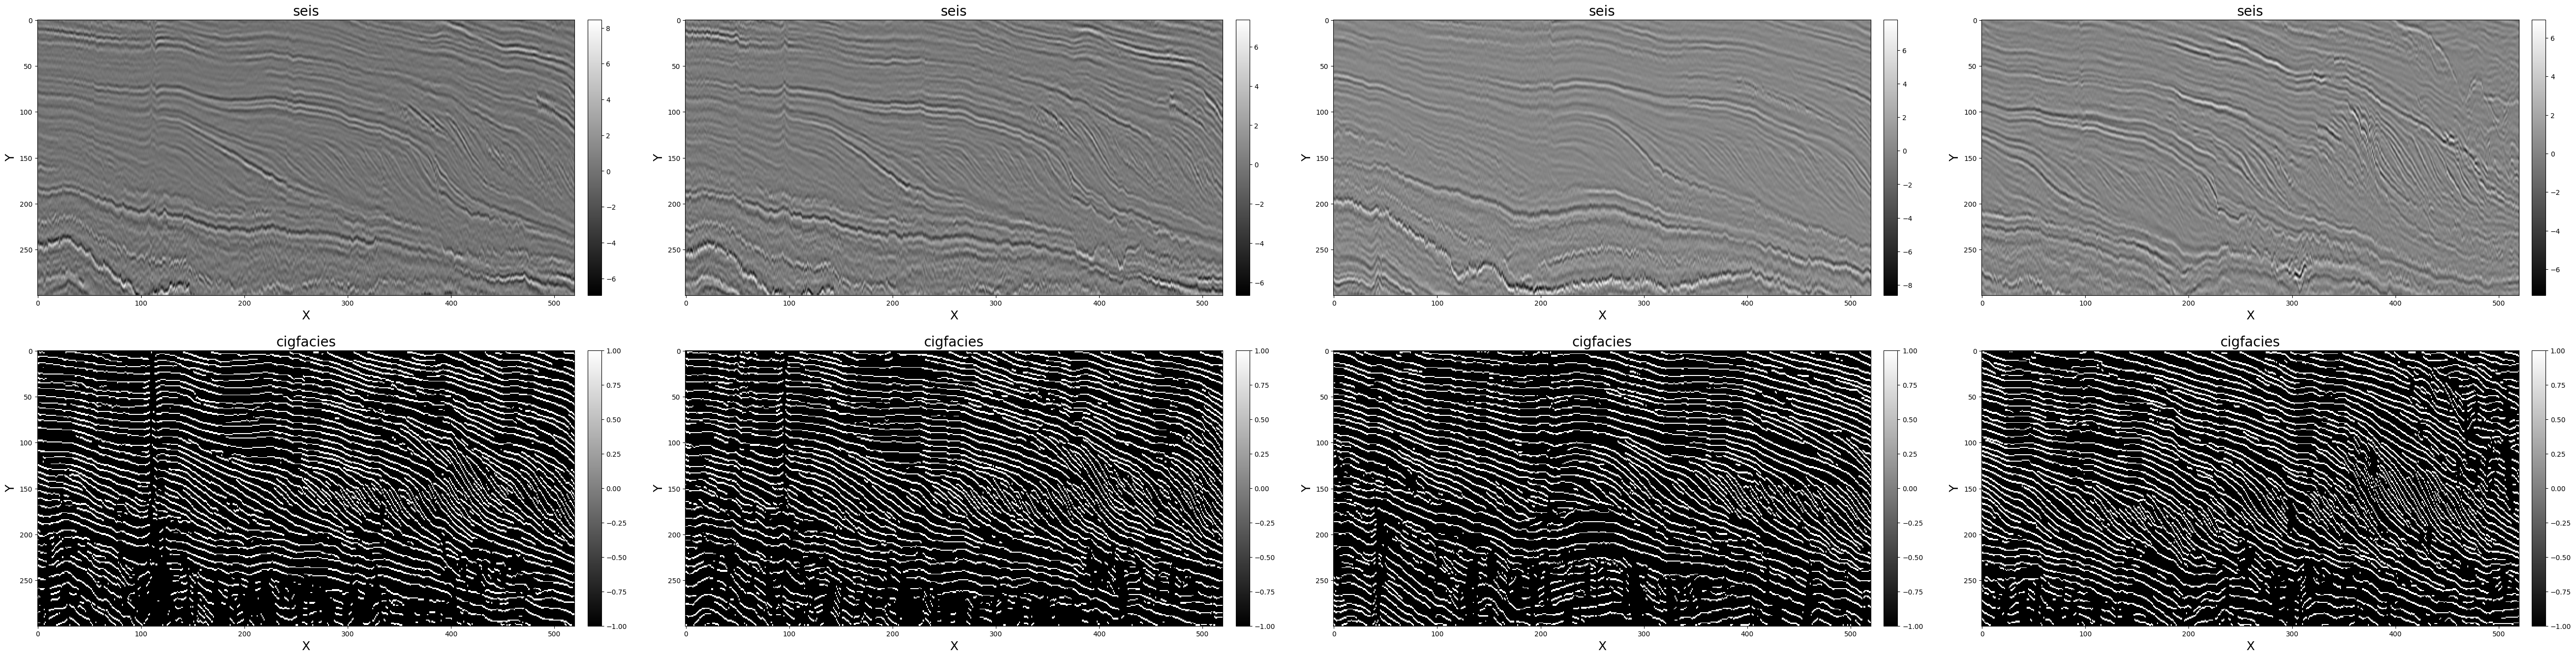

In [7]:
# plot
idxs = np.random.randint(0, len(train_data), size=4)
batch_samples = [train_data[i] for i in idxs]
draw_attr_list = input_attr_list + input_attr_list2 
draw.draw_samples(batch_samples, draw_attr_list, cmap=["gray","gray"],methods=["bilinear","nearest"])

In [8]:
# synthetic data
Valid_filename = "Train_Muti_largefold.npy"
root_path = os.path.abspath(".")
dataset_name = 'synthetic'
dataset_path = os.path.join(root_path, "dataset",dataset_name)
train_dataset_path = os.path.join(dataset_path, "syn")
samples_valid = np.load(os.path.join(dataset_path, Valid_filename), allow_pickle=True)
# samples_valid = samples_valid[0:num_sample]
samples_valid = samples_valid[0:400]
print(f"验证样本数量: {len(samples_valid)}")

train_sample_path = os.path.join(dataset_path, "syn_datasets_cigfacies")
synciglabel_path =  "./dataset/synthetic/syn_datasets_localhorizon/"
output_attr_list_syn, output_attr_list2_syn = ["rgt"], ["unconformities"]

syn_data =  utils.build_dataset_cigfacies(samples_valid, train_sample_path, 'Train',
                                            input_attr_list=input_attr_list,input_attr_list2=input_attr_list2,
                                            input_attr_list3=input_attr_list3,input_attr_list4=input_attr_list4,
                                            output_attr_list=output_attr_list_syn, output_attr_list2=output_attr_list2_syn)

验证样本数量: 400


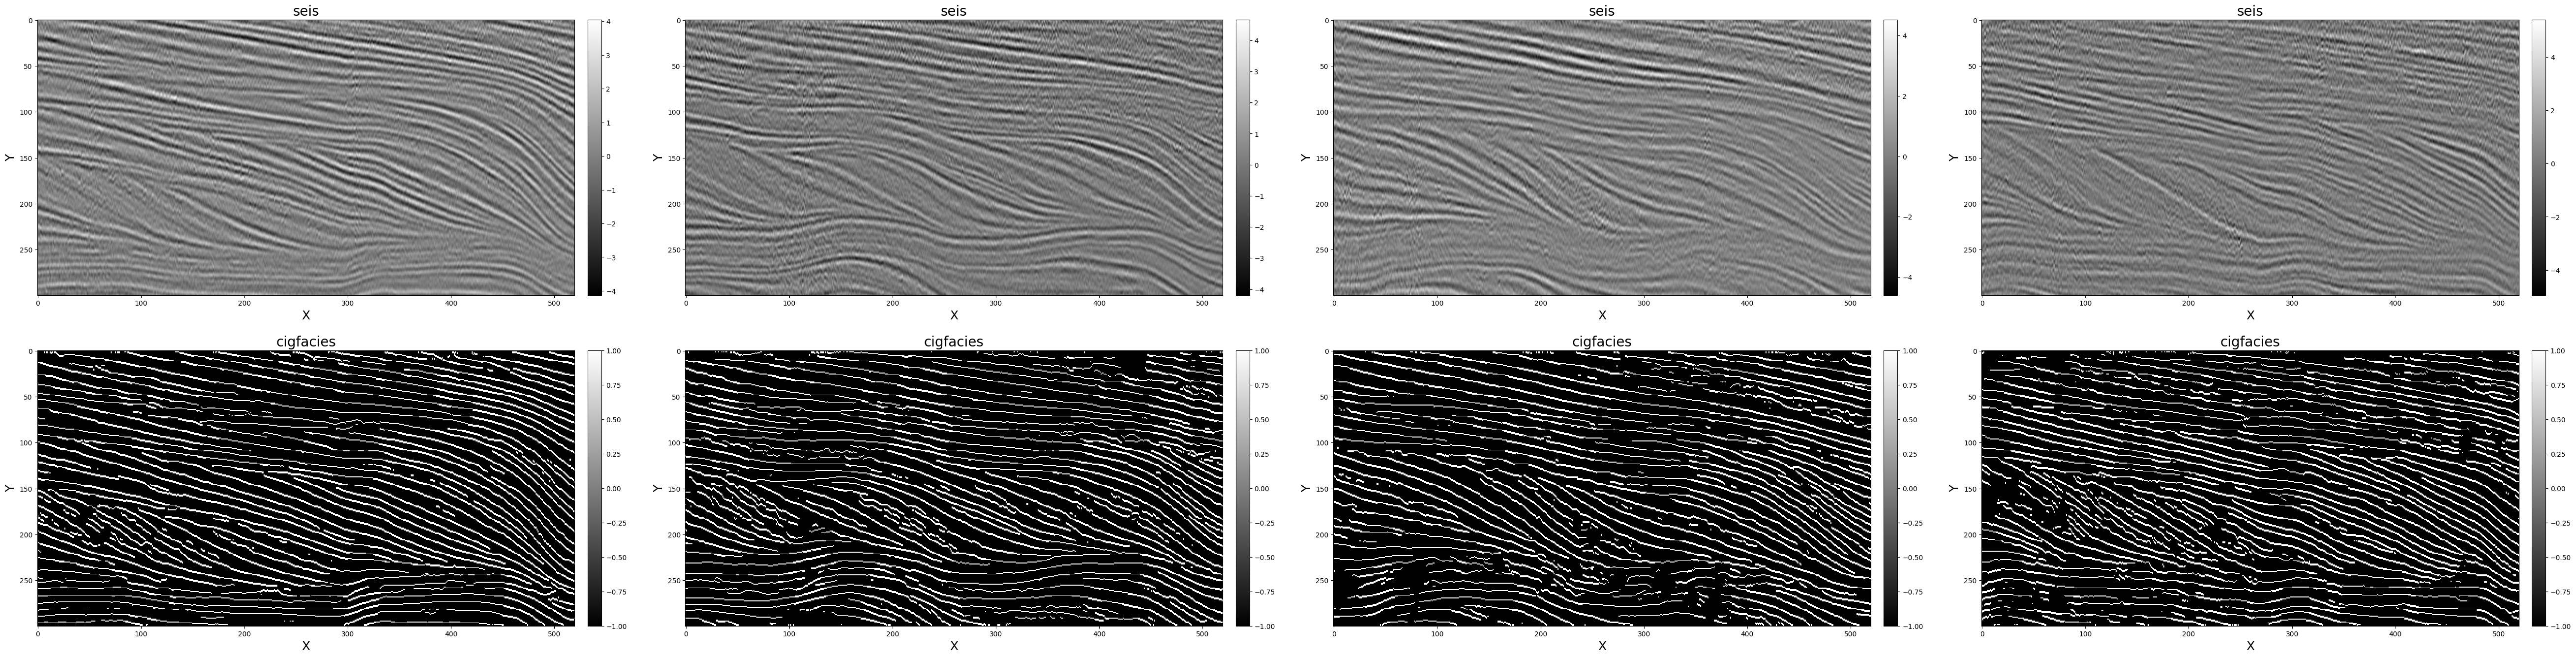

In [9]:
# plot
idxs = np.random.randint(0, len(syn_data), size=4)
batch_samples = [syn_data[i] for i in idxs]
draw_attr_list = input_attr_list + input_attr_list2 
draw.draw_samples(batch_samples, draw_attr_list, cmap=["gray","gray"],methods=["bilinear","nearest"])

In [10]:
from GLP.model import GLPDepth_merge,GLPDepth 
import loralib as lora

# model = GLPDepth(max_depth=10,is_train=True,use_lora=True)
model = GLPDepth_merge(max_depth=10,is_train=True,use_lora=True)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    model = model.to(device) 

pretrain_path = "./checkpoints/GLPmerge_cigfacies_L2SSIMCIGL1Norm/checkpoint-best.pth"
model.load_state_dict(torch.load(pretrain_path)['state_dict'],strict=False)

lora.mark_only_lora_as_trainable(model)
# lora.mark_only_lora_as_trainable(model,"all")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_params_ratio = trainable_params / total_params * 100
print(f"Total parameters: {total_params}, Trainable parameters: {trainable_params}, Trainable parameters ratio: {trainable_params_ratio:.2f}%")

# 模型保存路径
checkpoint_path = os.path.join('checkpoints', Modelname)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
print(f"模型读取路径: {checkpoint_path}")

/home/huig/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Loads checkpoint by local backend from path: ./GLP/weights/mit_b4.pth
The model and loaded state dict do not match exactly

size mismatch for patch_embed1.proj.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 7, 7]).
unexpected key in source state_dict: head.weight, head.bias

missing keys in source state_dict: block1.0.attn.q.lora_A, block1.0.attn.q.lora_B, block1.0.attn.kv.lora_A, block1.0.attn.kv.lora_B, block1.1.attn.q.lora_A, block1.1.attn.q.lora_B, block1.1.attn.kv.lora_A, block1.1.attn.kv.lora_B, block1.2.attn.q.lora_A, block1.2.attn.q.lora_B, block1.2.attn.kv.lora_A, block1.2.attn.kv.lora_B, block2.0.attn.q.lora_A, block2.0.attn.q.lora_B, block2.0.attn.kv.lora_A, block2.0.attn.kv.lora_B, block2.1.attn.q.lora_A, block2.1.attn.q.lora_B, block2.1.attn.kv.lora_A, block2.1.attn.kv.lora_B, block2.2.attn.q.lora_A, block2.2.attn.q.lora_B, block2.2.attn.kv.lora_A, block2.2.attn.kv.lora_B, block2.3.attn.q.lora_

In [11]:
# 定义训练参数
param = {}
param['epochs'] = 101    
param['batch_size'] = 32   
param['lr'] = 1e-3         
# SGD
param['gamma'] = 0.9      
param['step_size'] = 50  
param['momentum'] = 0.8    
# Adam
param['lr_factor'] = 0.5 
param['lr_patience'] = 2 
param['weight_decay'] = 0 

param['optimizer_type'] = 'Adam' 
param['checkpoint_path'] = checkpoint_path
param['disp_inter'] = 1 
param['save_inter'] = 5 

Epoch:0, Training Loss:1.22640 <0.8886+0.3378>, Synthetic Loss:0.64166, Learning rate: 0.001000 --> <0.93403>
Epoch:1, Training Loss:1.09267 <0.8038+0.2889>, Synthetic Loss:0.64887, Learning rate: 0.001000 --> <0.87077>
Epoch:2, Training Loss:1.01629 <0.7503+0.2660>, Synthetic Loss:0.63916, Learning rate: 0.001000 --> <0.82773>
Epoch:3, Training Loss:0.97837 <0.7197+0.2587>, Synthetic Loss:0.63755, Learning rate: 0.001000 --> <0.80796>
Epoch:4, Training Loss:0.95491 <0.7002+0.2547>, Synthetic Loss:0.63224, Learning rate: 0.001000 --> <0.79357>
Epoch:5, Training Loss:0.93991 <0.6881+0.2518>, Synthetic Loss:0.63212, Learning rate: 0.001000 --> <0.78601>
Epoch:6, Training Loss:0.92530 <0.6760+0.2493>, Synthetic Loss:0.62668, Learning rate: 0.001000 --> <0.77599>
Epoch:7, Training Loss:0.91584 <0.6665+0.2493>, Synthetic Loss:0.62844, Learning rate: 0.001000 --> <0.77214>
Epoch:8, Training Loss:0.90728 <0.6589+0.2484>, Synthetic Loss:0.62554, Learning rate: 0.001000 --> <0.76641>
Epoch:9, T

Epoch:74, Training Loss:0.72955 <0.4921+0.2374>, Synthetic Loss:0.61073, Learning rate: 0.000063 --> <0.67014>
Epoch:75, Training Loss:0.72835 <0.4923+0.2361>, Synthetic Loss:0.61577, Learning rate: 0.000031 --> <0.67206>
Epoch:76, Training Loss:0.72694 <0.4883+0.2386>, Synthetic Loss:0.60884, Learning rate: 0.000031 --> <0.66789>
Epoch:77, Training Loss:0.72864 <0.4935+0.2351>, Synthetic Loss:0.61629, Learning rate: 0.000031 --> <0.67246>
Epoch:78, Training Loss:0.73046 <0.4899+0.2406>, Synthetic Loss:0.61654, Learning rate: 0.000031 --> <0.67350>
Epoch:79, Training Loss:0.73211 <0.4921+0.2400>, Synthetic Loss:0.61191, Learning rate: 0.000031 --> <0.67201>
Epoch:80, Training Loss:0.72564 <0.4897+0.2360>, Synthetic Loss:0.61092, Learning rate: 0.000016 --> <0.66828>
Epoch:81, Training Loss:0.72702 <0.4905+0.2365>, Synthetic Loss:0.61194, Learning rate: 0.000016 --> <0.66948>
Epoch:82, Training Loss:0.72570 <0.4879+0.2378>, Synthetic Loss:0.61176, Learning rate: 0.000016 --> <0.66873>
E

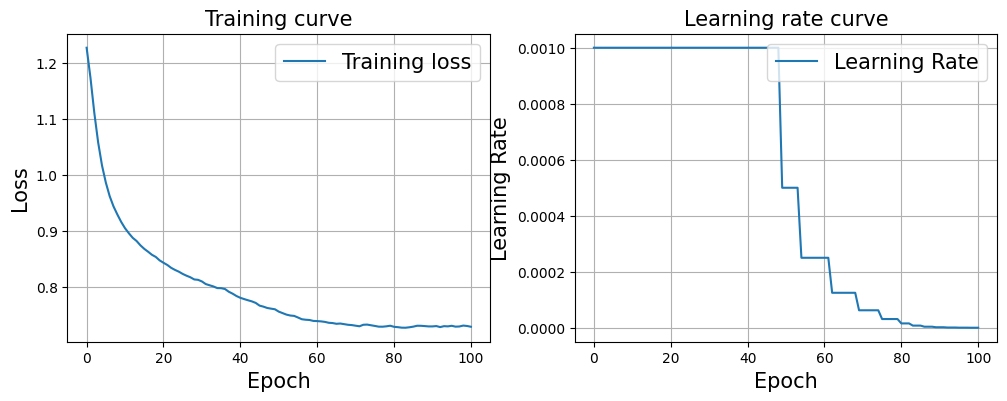

log has saved


In [12]:
model = utils.train_GLP_cigfacies_lorawithsyn(param, model, train_data,syn_data,
                                       ciglabel_dir = ciglabel_path,synciglabel_dir = synciglabel_path,
                                              ratio=[0.1,10,10],
                                       input_attrs=input_attr_list, input_attrs2=input_attr_list2,
                                       input_attrs3=input_attr_list3,input_attrs4=input_attr_list4,
                                       output_attrs=output_attr_list,output_attrs2=output_attr_list2, plot=True)

In [13]:
quit()